In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Working with Precomputed Databases
Sometimes we don't have access to a function, but are instead handed a database of simulations from which we are asked to extract insight.  In this example, we consider a collection of results generated by perturbing airfoil shapes in transonic flow regimes. (An oblique shock forming on the upper surface of the airfoil geometry.) The domain is a set of common Class-Shape Transformation parameters used to perturb the airfoil geometry. The parameters consist of 5 coefficients in an upper surface polynomial expansion and 5 coefficients in a lower surface polynomial expansion for a total of a 10-dimensional domain. The function reponses are the associated coefficients of lift and drag as line integrals over the airfoil boundary. These coefficients represent the amount of vertically generated force (lift) in contrast with the horizontally generated force (drag).

In [2]:
import numpy as np
import scipy.io
import psdr

## Importing data
Here we use standard scipy tools to import the saved data in a `.mat` file.  We also bring in the lower and upper bounds so that we can construct the normalized domain. We first read in the lift results then the drag results. The domain information is common between the two `.mat` files.

In [3]:
# Import ASAP saved data
dat = scipy.io.loadmat('./data/AS_m10_N1000_pm60pct_Lift.mat')
X_app = dat['X0']
lb = dat['lb0'].flatten()
ub = dat['ub0'].flatten()
CL = dat['F'].flatten()
dat = scipy.io.loadmat('./data/AS_m10_N1000_pm60pct_Drag.mat')
CD = dat['F'].flatten()

## Normalized Units
Unlike working with functions, we need to be careful to convert into normalized units before performing any analysis.  Here we construct a box domain, a normalized box domain ($[-1,1]^n$), and convert the inputs in the application units into the normalized domain.

In [4]:
dom_app = psdr.BoxDomain(lb, ub)
dom = dom_app.normalized_domain()
X = dom_app.normalize(X_app)

## Identifying Low-Dimensional Structure
We next execute the routine to compute a polynmial ridge approximation for the response with a quadratic and corresponding subspace dimensionality

The R**2 Coefs. of Determination are,
Lift R**2: 0.9862104874448646
Drag R**2: 0.784926439506455


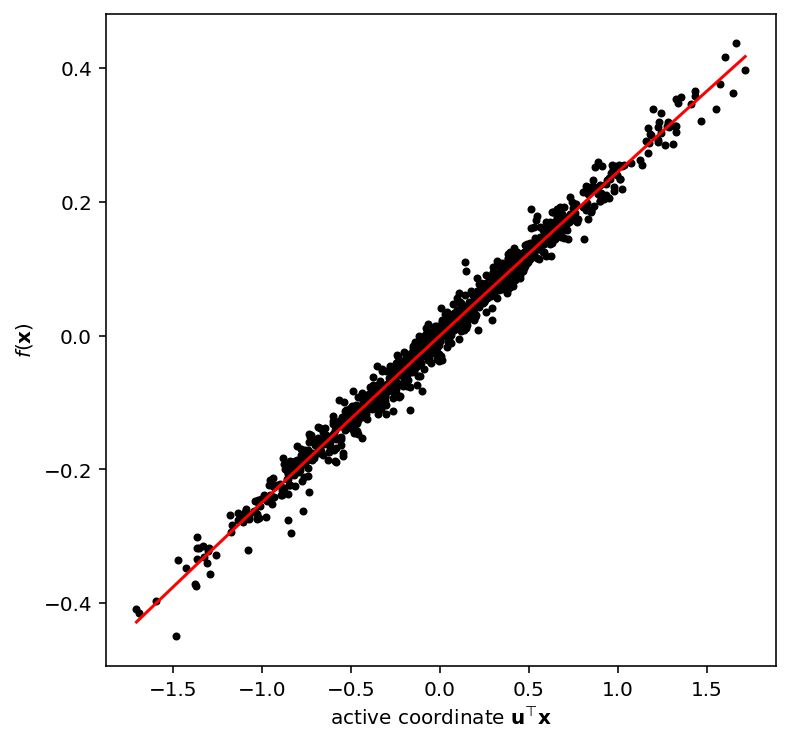

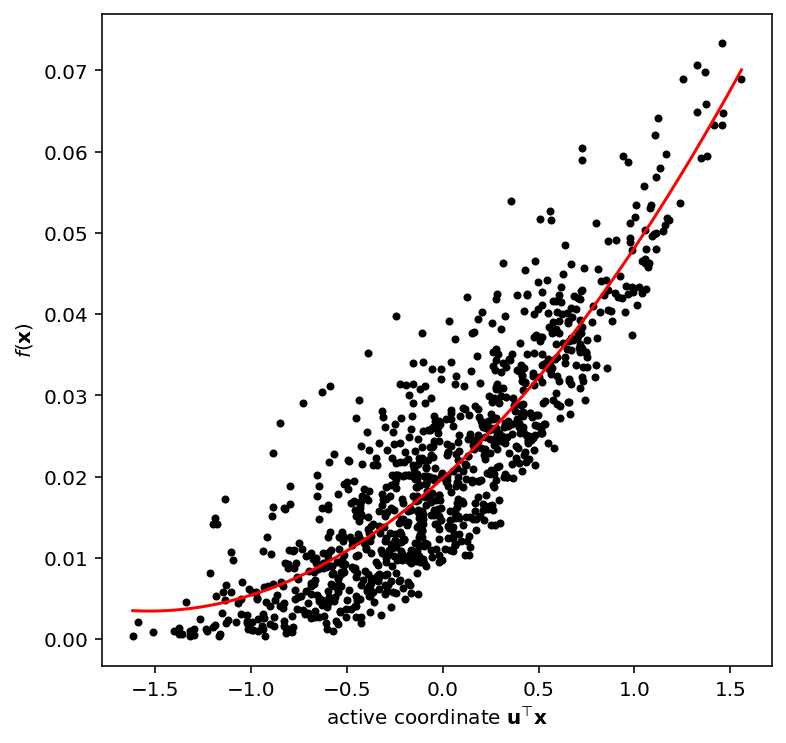

In [5]:
# try Polynomial Ridge Approximation with a 1-dimensional subspace for lift and drag
pra = psdr.PolynomialRidgeApproximation(degree = 2,subspace_dimension = 1)
pra.fit(X,CL)
ax = pra.shadow_plot(X,CL)
Rsqd_Cl = 1 - np.linalg.norm(pra(X) - CL)**2 / np.linalg.norm(CL - np.mean(CL))**2
pra.fit(X,CD)
ax = pra.shadow_plot(X,CD)
Rsqd_Cd = 1 - np.linalg.norm(pra(X) - CD)**2 / np.linalg.norm(CD - np.mean(CD))**2
print('The R**2 Coefs. of Determination are,')
print("Lift R**2: {}".format(Rsqd_Cl))
print("Drag R**2: {}".format(Rsqd_Cd))

Since the approximation of drag is somewhat poor, (only capturing about 22% of the sample variation in the response) we increase the dimension of the subspace for polynomial ridge approximation and rerun.

Drag R**2: 0.8705276236993824


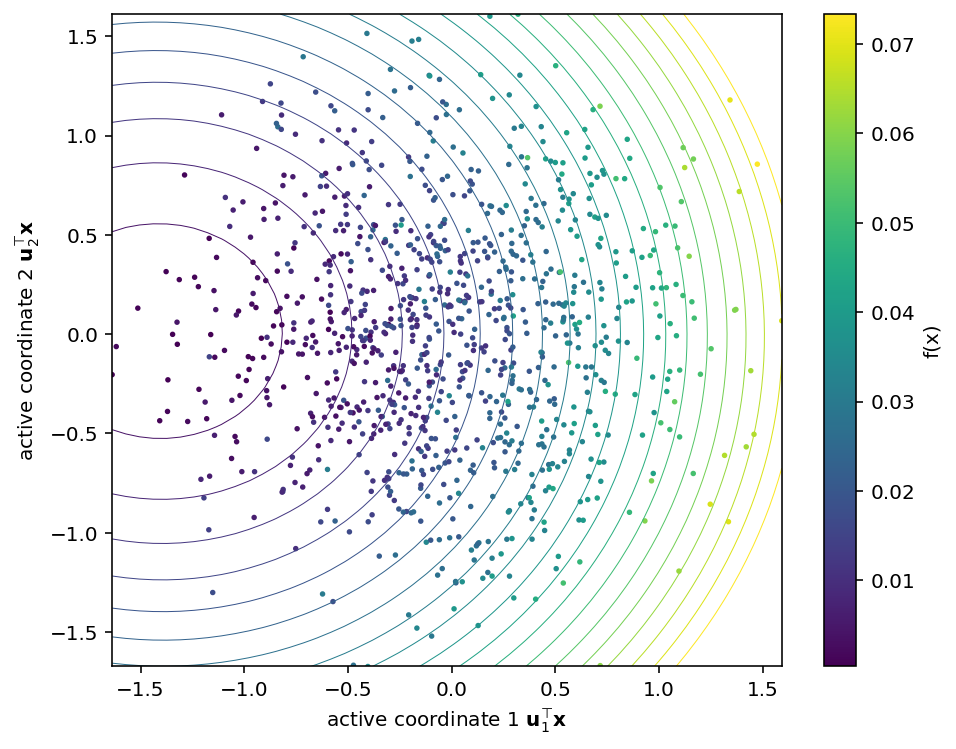

In [10]:
pra = psdr.PolynomialRidgeApproximation(degree = 2,subspace_dimension = 2)
pra.fit(X,CD)
ax = pra.shadow_plot(X,CD)
Rsqd_Cd = 1 - np.linalg.norm(pra(X) - CD)**2 / np.linalg.norm(CD - np.mean(CD))**2
print("Drag R**2: {}".format(Rsqd_Cd))

Terrific! We've gained another 10% in the description of the drag sample variation by increasing the dimensionality of the approximation. These results closely agree with the published work (using monomial surrgates to approximate active subspaces) of a predominantly 1-dimensional response for lift and 2-dimensional response for drag:

@article{grey2018active,
  title={Active subspaces of airfoil shape parameterizations},
  author={Grey, Zachary J and Constantine, Paul G},
  journal={AIAA Journal},
  volume={56},
  number={5},
  pages={2003--2017},
  year={2018},
  publisher={American Institute of Aeronautics and Astronautics}
}